# Сборный проект №2 | Кутивадзе Георгий

## Описание проекта <a id='0'></a>

**Заказчик**: компания, желающая оптимизировать управление персоналом

**Бизнес проблема**: компании необходимо грамотно управлять удовлетворённостью работой сотрудников, поскольку это напрямую влияет на их отток, предсказание которого — одна из важнейших задач стоящей перед компанией. Внезапные увольнения несут в себе риски, особенно если уходит важный сотрудник.  

**Цель проекта**: обеспечить заказчику возможность предсказывать удовлетвренность сотрудников и их отток на основе данных компании.

**Задача проекта №1**: построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика.

**Задача проекта №2**: построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.

**План проекта**:  

- [Описание и загрузка данных](#1)
- [Изучение и предобработка данных](#2)
- [Исследовательский и корреляционный анализ данных](#3)
- [Задача №1](#4)
    - [Подготовка данных к обучению](#5)
    - [Обучение моделей](#6)
    - [Промежуточные выводы](#7)
- [Задача №2](#8)
    - [Подготовка данных к обучению](#9)
    - [Обучение моделей](#10)
    - [Промежуточные выводы](#11)
- [Общий вывод](#12)

In [1]:
# Importing libraries
!pip install --upgrade scikit-learn -q
!pip install shap -q
!pip install phik -q

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import phik
from scipy import stats as st
from scipy.stats import spearmanr

from sklearn.preprocessing import (
    OneHotEncoder, StandardScaler, OrdinalEncoder, 
    MinMaxScaler, LabelEncoder
)
from sklearn.model_selection import (
    train_test_split, GridSearchCV, RandomizedSearchCV
)
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import (
    make_scorer, r2_score, mean_absolute_error, 
    mean_squared_error, confusion_matrix, recall_score, 
    precision_score, accuracy_score, roc_auc_score
)
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from phik.report import plot_correlation_matrix

## Описание и загрузка данных <a id='1'> <a>

Для реализации задач заказчик предоставил данные с признаками:

- `id` — уникальный идентификатор сотрудника;
- `dept` — отдел, в котором работает сотрудник;
- `level` — уровень занимаемой должности;
- `workload` — уровень загруженности сотрудника;
- `employment_years` — длительность работы в компании (в годах);
- `last_year_promo` — показывает, было ли повышение за последний год;
- `last_year_violations` — показывает, нарушал ли сотрудник трудовой договор за последний год;
- `supervisor_evaluation` — оценка качества работы сотрудника, которую дал руководитель;
- `salary` — ежемесячная зарплата сотрудника;
- `job_satisfaction_rate` — уровень удовлетворённости сотрудника работой в компании (целевой признак задачи №1)
- `quit` - ушел или не ушел сотрдурник (целевой признак задачи №2)

Данные предоставлены в разрезе задачи и типа выборки - тренировочная и две тестовых (признаковое описание и таргет) для каждый задачи:

**Задача №1**:
- Тренировочная выборка:
`train_job_satisfaction_rate.csv`
- Входные признаки тестовой выборки:
`test_features.csv`
- Целевой признак тестовой выборки:
`test_target_job_satisfaction_rate.csv`

**Задача №2**:
- Тренировочная выборка:
`train_quit.csv`
- Входные признаки тестовой выборки те же, что и в прошлой задаче:
`test_features.csv`
- Целевой признак тестовой выборки:
`test_target_quit.csv`


Загрузим вышеуказанные данные:

In [2]:
#defing a function to import data
def csv_reader(pth):
    if os.path.exists(pth):
        return pd.read_csv(pth)
    elif os.path.exists(os.path.join('/datasets', pth)):
        return pd.read_csv(os.path.join('/datasets', pth))
    
#task 1
train_job_satisfaction_rate = csv_reader('train_job_satisfaction_rate.csv')
test_features = csv_reader('test_features.csv')
test_target_job_satisfaction_rate = csv_reader('test_target_job_satisfaction_rate.csv')

#task 2
train_quit = csv_reader('train_quit.csv')
test_target_quit = csv_reader('test_target_quit.csv')

## Изучение и предобработка данных <a id='2'> <a>

### Изучение данных

Воспользуемся функцией, которая выводит основную информацию о датафрейме:

In [3]:
def main_info_about_df(df):
    display(df.head())
    print('-----------------------------------------')
    display(df.info())
    print('-----------------------------------------')
    print('Размер таблицы: ', df.shape)
    print('-----------------------------------------')
    print('Количество явных дубликатов: ', df.duplicated().sum())
    print('-----------------------------------------')
    print('Количество пропусков в каждом столбце таблицы:')
    display(pd.DataFrame(df.isna().sum()))
    print('-----------------------------------------')
    print('Описательная статистика:')
    display(pd.DataFrame(df.describe()))

In [4]:
main_info_about_df(train_job_satisfaction_rate)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


-----------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


None

-----------------------------------------
Размер таблицы:  (4000, 10)
-----------------------------------------
Количество явных дубликатов:  0
-----------------------------------------
Количество пропусков в каждом столбце таблицы:


,0
id,0
dept,6
level,4
workload,0
employment_years,0
last_year_promo,0
last_year_violations,0
supervisor_evaluation,0
salary,0
job_satisfaction_rate,0


-----------------------------------------
Описательная статистика:


,id,employment_years,supervisor_evaluation,salary,job_satisfaction_rate
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,544957.621000,3.718500,3.476500,33926.700000,0.533995
std,257883.104622,2.542513,1.008812,14900.703838,0.225327
min,100954.000000,1.000000,1.000000,12000.000000,0.030000
25%,322836.750000,2.000000,3.000000,22800.000000,0.360000
50%,534082.500000,3.000000,4.000000,30000.000000,0.560000
75%,771446.000000,6.000000,4.000000,43200.000000,0.710000
max,999521.000000,10.000000,5.000000,98400.000000,1.000000


Проверим на предмет неявных дубликатов:

In [5]:
for col in ['dept', 'level', 'workload', 'last_year_violations', 'supervisor_evaluation']:
    display(pd.DataFrame(train_job_satisfaction_rate[col].value_counts()))

,count
dept,
sales,1512
technology,866
purchasing,610
marketing,550
hr,456


,count
level,
junior,1894
middle,1744
sinior,358


,count
workload,
medium,2066
low,1200
high,734


,count
last_year_violations,
no,3441
yes,559


,count
supervisor_evaluation,
4,1603
3,1263
5,546
2,387
1,201


In [6]:
train_job_satisfaction_rate[train_job_satisfaction_rate['dept'].isna()==True]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
1526,694746,NaN,junior,medium,5,no,no,4,21600,0.62
1630,814624,NaN,junior,medium,3,no,no,4,24000,0.88
1633,475114,NaN,junior,high,4,no,no,4,31200,0.63
2781,497243,NaN,junior,medium,1,no,no,3,26400,0.28
2975,168668,NaN,junior,low,3,no,no,4,18000,0.88
3866,641150,NaN,junior,low,3,no,yes,4,12000,0.54


In [7]:
train_job_satisfaction_rate[train_job_satisfaction_rate['level'].isna()==True]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
1209,631073,sales,NaN,medium,1,no,no,4,27600,0.66
1469,416327,sales,NaN,low,1,no,no,5,18000,0.73
1745,135043,sales,NaN,medium,1,no,no,3,26400,0.30
2522,998838,sales,NaN,medium,1,no,no,5,27600,0.71


Проверим данные на наличие полных дубликатов в выборке без id:

In [8]:
train_job_satisfaction_rate.drop(['id'], axis=1).duplicated().sum()

245

Заметим, что таких дубликатов 245 штук. Перед обучением они будут удалены из выборки, поскольку могут привести к переобучению и смещению метрик.

Заметим, что:
- в таблице `4000` записей;
- в данных присутствуют `245 дубликатов` (без id), перед обучением моделей они будут `удалены`;
- типы данных в порядке;
- названия столбцов в `змеином порядке`;
- есть пропуски: `6` пропусков в столбце `dept` и `4` пропуска в столбце `level`;
- выбросов и аномалий в данных `не наблюдается`.

In [9]:
main_info_about_df(test_features)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


-----------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


None

-----------------------------------------
Размер таблицы:  (2000, 9)
-----------------------------------------
Количество явных дубликатов:  0
-----------------------------------------
Количество пропусков в каждом столбце таблицы:


,0
id,0
dept,2
level,1
workload,0
employment_years,0
last_year_promo,0
last_year_violations,0
supervisor_evaluation,0
salary,0


-----------------------------------------
Описательная статистика:


,id,employment_years,supervisor_evaluation,salary
count,2000.000000,2000.000000,2000.000000,2000.000000
mean,552765.213500,3.666500,3.526500,34066.800000
std,253851.326129,2.537222,0.996892,15398.436729
min,100298.000000,1.000000,1.000000,12000.000000
25%,339052.000000,1.000000,3.000000,22800.000000
50%,550793.000000,3.000000,4.000000,30000.000000
75%,765763.750000,6.000000,4.000000,43200.000000
max,999029.000000,10.000000,5.000000,96000.000000


Проверим на предмет неявных дубликатов:

In [10]:
for col in ['dept', 'level', 'workload', 'last_year_violations', 'supervisor_evaluation']:
    display(pd.DataFrame(test_features[col].value_counts()))

,count
dept,
sales,763
technology,455
marketing,279
purchasing,273
hr,227
,1


,count
level,
junior,974
middle,854
sinior,171


,count
workload,
medium,1043
low,593
high,363
,1


,count
last_year_violations,
no,1738
yes,262


,count
supervisor_evaluation,
4,857
3,575
5,284
2,196
1,88


In [11]:
test_features[test_features['dept'].isna() == True]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
191,609865,NaN,junior,medium,1,no,no,1,20400
1196,832342,NaN,junior,medium,1,no,no,4,28800


In [12]:
test_features[test_features['dept'] == ' ']

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
1699,822186,,middle,medium,3,no,no,4,38400


In [13]:
test_features[test_features['level'].isna() == True]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
312,471990,sales,NaN,low,1,no,no,3,12000


In [14]:
test_features[test_features.workload==' ']

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
15,590867,marketing,junior,,4,no,no,4,28800


In [15]:
test_features.replace(' ', np.nan, inplace=True)

Проверим данные на наличие полных дубликатов в выборке без id:

In [16]:
test_features.drop(['id'], axis=1).duplicated().sum()

557

Заметим, что таких дубликатов 557 штук. Перед обучением они будут удалены из выборки, поскольку могут привести к переобучению и смещению метрик.

Заметим, что:
- в таблице `2000` записей;
- в данных присутствуют `557 дубликатов` (без id), перед обучением моделей они будут `удалены`;
- названия столбцов в `змеином порядке`;
- есть пропуски: `2` пропуска в столбце `dept` и `1` пропуск в столбце `level`;
- в двух записях имеется `пробел` вместо значения (заменилих их на NaN для дальнейшей обработки);
- выбросов и аномалий в данных `не наблюдается`.

In [17]:
main_info_about_df(test_target_job_satisfaction_rate)

,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


-----------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


None

-----------------------------------------
Размер таблицы:  (2000, 2)
-----------------------------------------
Количество явных дубликатов:  0
-----------------------------------------
Количество пропусков в каждом столбце таблицы:


,0
id,0
job_satisfaction_rate,0


-----------------------------------------
Описательная статистика:


,id,job_satisfaction_rate
count,2000.000000,2000.00000
mean,552765.213500,0.54878
std,253851.326129,0.22011
min,100298.000000,0.03000
25%,339052.000000,0.38000
50%,550793.000000,0.58000
75%,765763.750000,0.72000
max,999029.000000,1.00000


Заметим, что:
- в таблице `2000` записей;
- явные и неявные `дубликаты отсутствуют`;
- типы данных в порядке;
- названия столбцов в `змеином порядке`;
- пропусков нет;
- выбросов и аномалий в данных `не наблюдается`.

In [18]:
main_info_about_df(train_quit)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


-----------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


None

-----------------------------------------
Размер таблицы:  (4000, 10)
-----------------------------------------
Количество явных дубликатов:  0
-----------------------------------------
Количество пропусков в каждом столбце таблицы:


,0
id,0
dept,0
level,0
workload,0
employment_years,0
last_year_promo,0
last_year_violations,0
supervisor_evaluation,0
salary,0
quit,0


-----------------------------------------
Описательная статистика:


,id,employment_years,supervisor_evaluation,salary
count,4000.000000,4000.000000,4000.000000,4000.000000
mean,552099.283750,3.701500,3.474750,33805.800000
std,260158.031387,2.541852,1.004049,15152.415163
min,100222.000000,1.000000,1.000000,12000.000000
25%,327785.750000,2.000000,3.000000,22800.000000
50%,546673.000000,3.000000,4.000000,30000.000000
75%,781497.750000,6.000000,4.000000,43200.000000
max,999915.000000,10.000000,5.000000,96000.000000


In [19]:
for col in ['dept', 'level', 'workload', 'last_year_violations', 'supervisor_evaluation', 'quit']:
    display(pd.DataFrame(train_quit[col].value_counts()))

,count
dept,
sales,1438
technology,928
purchasing,588
marketing,582
hr,464


,count
level,
junior,1949
middle,1694
sinior,357


,count
workload,
medium,2118
low,1208
high,674


,count
last_year_violations,
no,3455
yes,545


,count
supervisor_evaluation,
4,1654
3,1233
5,520
2,391
1,202


,count
quit,
no,2872
yes,1128


Проверим данные на наличие полных дубликатов в выборке без id:

In [20]:
train_quit.drop(['id'], axis=1).duplicated().sum()

1413

Заметим, что таких дубликатов 1413 штук. Перед обучением они будут удалены из выборки, поскольку могут привести к переобучению и смещению метрик.

Заметим, что:
- в таблице `4000` записей;
- в данных присутствуют `1413 дубликатов` (без id), перед обучением моделей они будут `удалены`;
- типы данных в порядке;
- названия столбцов в `змеином порядке`;
- пропусков нет;
- выбросов и аномалий в данных `не наблюдается`.

In [21]:
main_info_about_df(test_target_quit)

,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


-----------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


None

-----------------------------------------
Размер таблицы:  (2000, 2)
-----------------------------------------
Количество явных дубликатов:  0
-----------------------------------------
Количество пропусков в каждом столбце таблицы:


,0
id,0
quit,0


-----------------------------------------
Описательная статистика:


,id
count,2000.000000
mean,552765.213500
std,253851.326129
min,100298.000000
25%,339052.000000
50%,550793.000000
75%,765763.750000
max,999029.000000


Заметим, что:
- в таблице `2000` записей;
- явные и неявные `дубликаты отсутствуют`;
- типы данных в порядке;
- названия столбцов в `змеином порядке`;
- пропусков нет;
- выбросов и аномалий в данных `не наблюдается`.

### Предобработка данных

Заполним пропуски в таблице `train_job_satisfaction_rate` и `test_features`, используя `Pipeline`. Заменим пропуски наиболее популярным значениемx:

In [22]:
imputer = SimpleImputer(
    missing_values=np.nan,
    strategy='most_frequent'
)

pipeline_imputer = Pipeline([('imputer', imputer)])

In [23]:
train_job_satisfaction_rate_filled = pd.DataFrame(
    pipeline_imputer.fit_transform(train_job_satisfaction_rate),
    columns=train_job_satisfaction_rate.columns)

test_features_filled = pd.DataFrame(
    pipeline_imputer.fit_transform(test_features), columns=test_features.columns)

Заметим, что в наименовании старжей должности в данных допущена ошибка: "sinior" вместо "senior". Исправим это:

In [24]:
train_job_satisfaction_rate_filled.level = train_job_satisfaction_rate_filled.level.apply(lambda x: 'senior' if x == 'sinior' else x)
test_features_filled.level = test_features_filled.level.apply(lambda x: 'senior' if x == 'sinior' else x)
train_quit.level = train_quit.level.apply(lambda x: 'senior' if x == 'sinior' else x)

<div class="alert"; style="border-left: 7px solid pink">

**Мини-вывод**
- В таблицах `train_job_satisfaction_rate` и `test_features` имелись пропуски (в том числе неявные) - они были заменены на наиболее частое значения с помощью Pipeline;
- Дренировочные данные имеют `4000` записей, тестовые `2000`;
- Дубликаты `присутствуют` в значениях признаков (не считая id) в тренировочных и тестовых данных;
- Типы данных `в порядке`;
- Названия столбцов `в змеином порядке`.
</div>

## Исследовательский и корреляционный анализ данных <a id='3'> <a>

Посмотрим на распределения значений параметров и основные статистические характеристики данных в данных (). Ввиду того, что тренировочные данные представлены для разных сотрудников, они буду проанализированы отдельно.

### Тренировочные выборки

Создадим списки с наименованием категориальных и количественных признаков:

In [25]:
cat_cols = ['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations']

num_cols_job_satisfaction_rate = ['employment_years', 'supervisor_evaluation','salary', 'job_satisfaction_rate']

num_cols_quit = ['employment_years', 'supervisor_evaluation','salary']

Построим гистограмму и ящик с усами для количественным признаков `train_job_satisfaction_rate`:

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


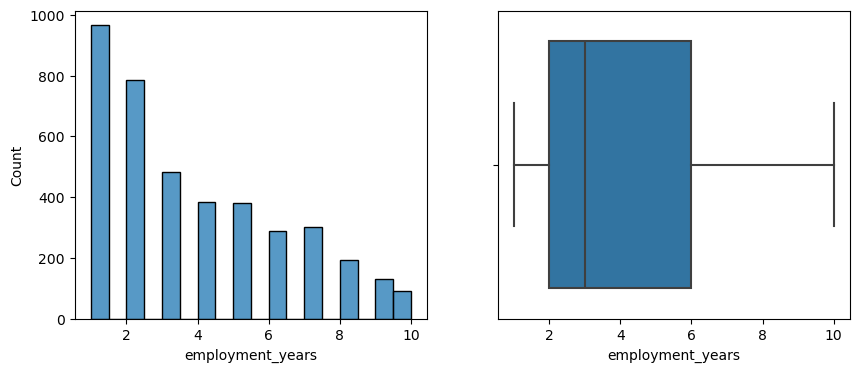

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


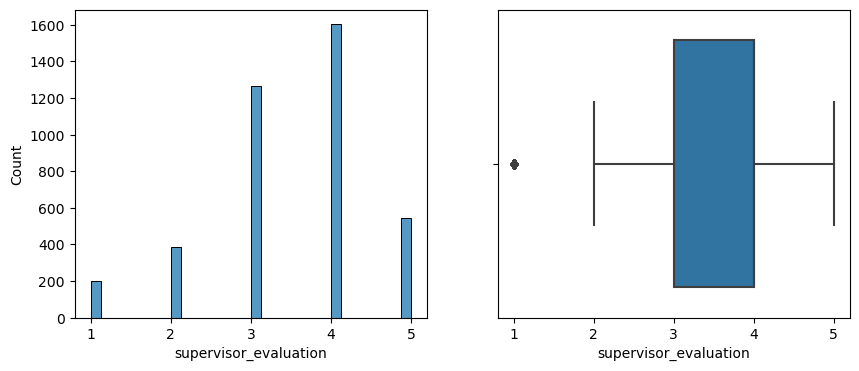

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


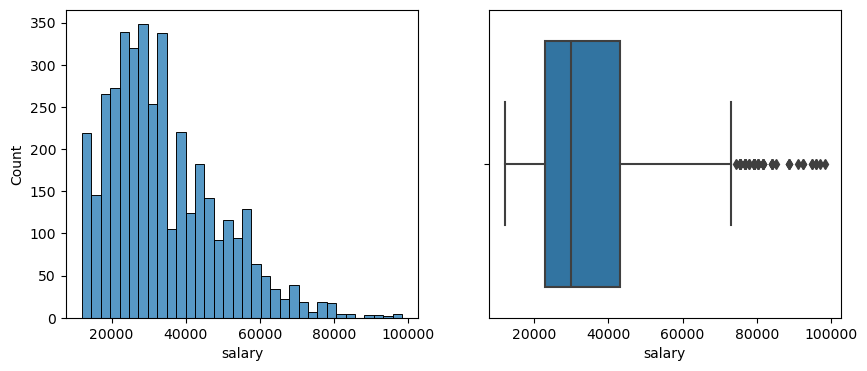

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


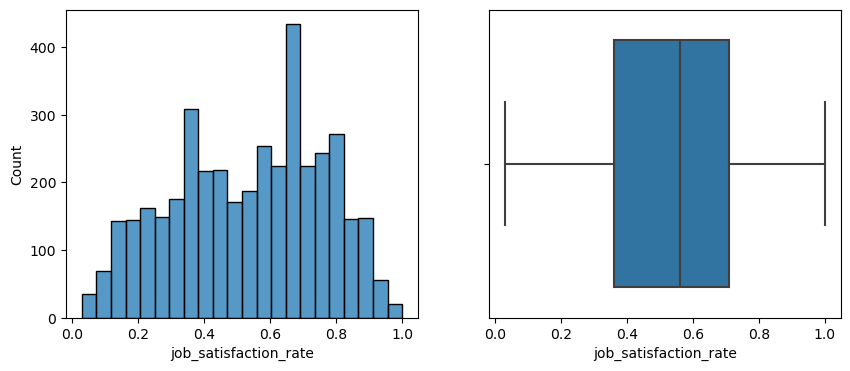

In [26]:
for num_column in num_cols_job_satisfaction_rate:
    plt.rcParams['figure.figsize'] = 10, 4
    plt.subplot(1, 2, 1)
    sns.histplot(data=train_job_satisfaction_rate_filled, x=num_column)
    plt.subplot(1, 2, 2)
    sns.boxplot(data=train_job_satisfaction_rate_filled, x=num_column)
    plt.show()

In [27]:
train_job_satisfaction_rate_filled.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.2


In [28]:
train_job_satisfaction_rate.describe()

,id,employment_years,supervisor_evaluation,salary,job_satisfaction_rate
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,544957.621000,3.718500,3.476500,33926.700000,0.533995
std,257883.104622,2.542513,1.008812,14900.703838,0.225327
min,100954.000000,1.000000,1.000000,12000.000000,0.030000
25%,322836.750000,2.000000,3.000000,22800.000000,0.360000
50%,534082.500000,3.000000,4.000000,30000.000000,0.560000
75%,771446.000000,6.000000,4.000000,43200.000000,0.710000
max,999521.000000,10.000000,5.000000,98400.000000,1.000000


Построим гистограмму и ящик с усами для количественным признаков `train_quit`:

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


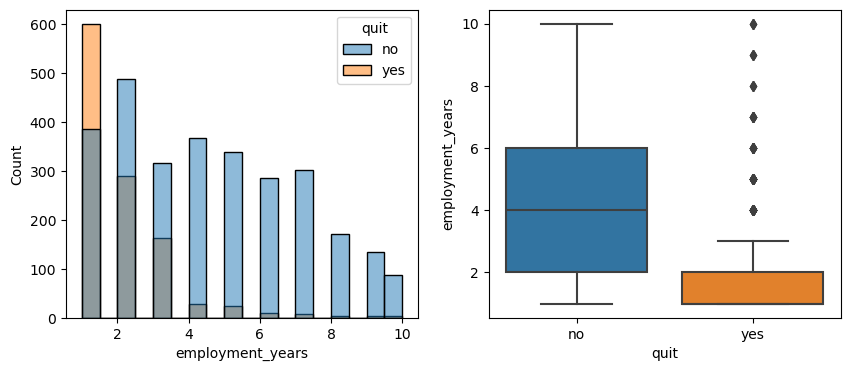

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


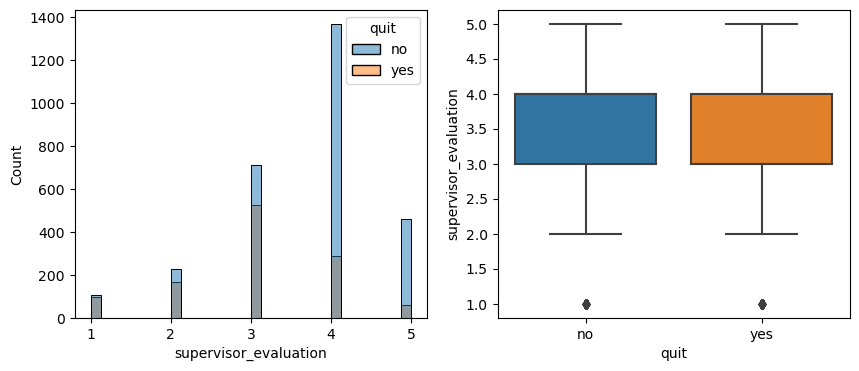

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


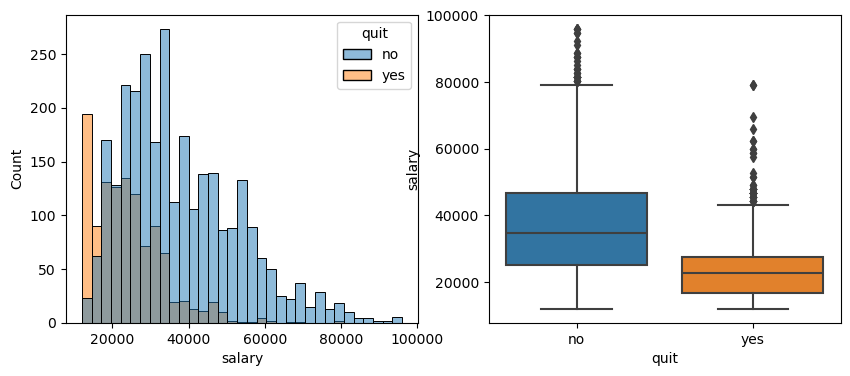

In [29]:
for num_column in num_cols_quit:
    plt.rcParams['figure.figsize'] = 10, 4
    plt.subplot(1, 2, 1)
    sns.histplot(data=train_quit, x=num_column, hue='quit')
    plt.subplot(1, 2, 2)
    sns.boxplot(data=train_quit, y=num_column, x='quit')
    plt.show()

In [30]:
train_quit.describe()

,id,employment_years,supervisor_evaluation,salary
count,4000.000000,4000.000000,4000.000000,4000.000000
mean,552099.283750,3.701500,3.474750,33805.800000
std,260158.031387,2.541852,1.004049,15152.415163
min,100222.000000,1.000000,1.000000,12000.000000
25%,327785.750000,2.000000,3.000000,22800.000000
50%,546673.000000,3.000000,4.000000,30000.000000
75%,781497.750000,6.000000,4.000000,43200.000000
max,999915.000000,10.000000,5.000000,96000.000000


Построим круговые диаграммы для категориальных признаков таблицы `train_job_satisfaction_rate`:

Круговая диаграмма для признака "dept"


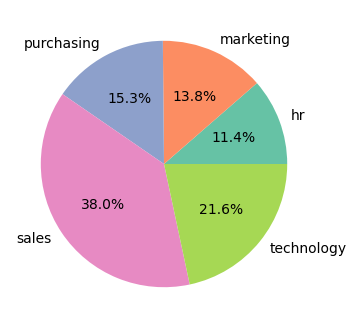

Круговая диаграмма для признака "level"


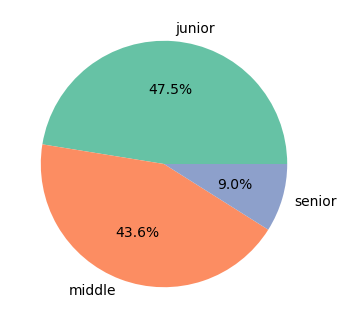

Круговая диаграмма для признака "workload"


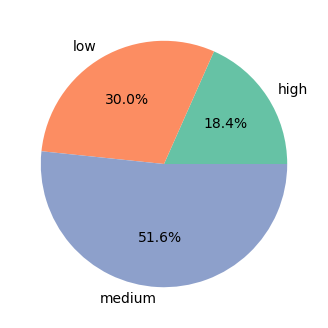

Круговая диаграмма для признака "last_year_promo"


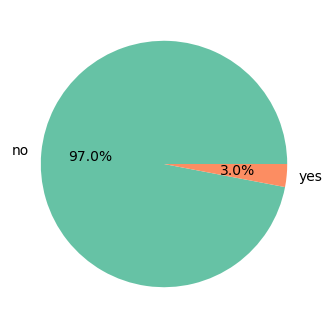

Круговая диаграмма для признака "last_year_violations"


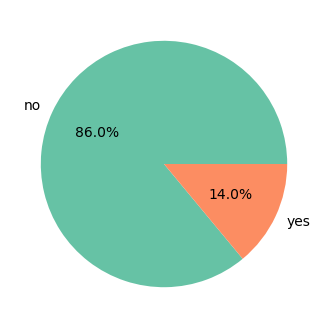

In [31]:
for cat_column in cat_cols:
    print(f'Круговая диаграмма для признака "{cat_column}"')
    plt.rcParams['figure.figsize'] = 4, 4
    x=train_job_satisfaction_rate_filled.groupby([cat_column])[cat_column].count()
    plt.pie(x=x, labels=x.index, autopct='%1.1f%%', colors=plt.cm.Set2.colors)
    plt.show()

Построим круговые диаграммы для категориальных признаков таблицы `train_quit`:

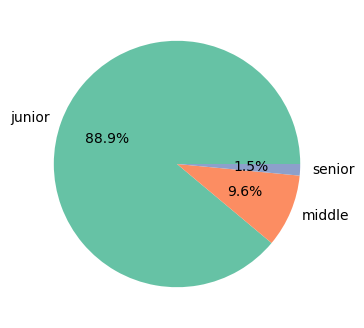

In [32]:
plt.rcParams['figure.figsize'] = 4, 4
x=train_quit[train_quit['quit'] == 'yes'].groupby(['level'])['level'].count()
plt.pie(x=x, labels=x.index, autopct='%1.1f%%', colors=plt.cm.Set2.colors)
plt.show()

Круговая диаграмма для признака "dept"


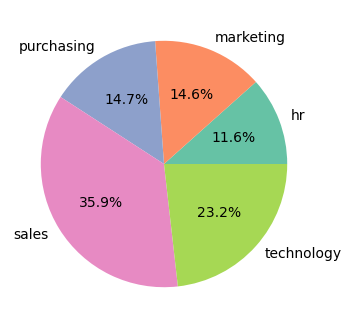

Круговая диаграмма для признака "level"


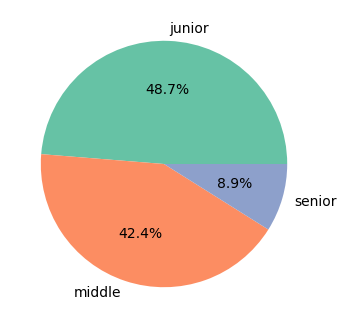

Круговая диаграмма для признака "workload"


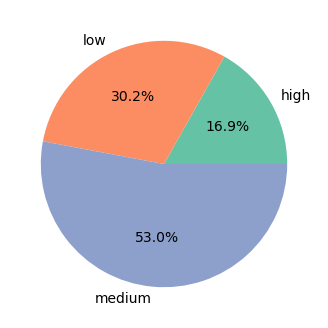

Круговая диаграмма для признака "last_year_promo"


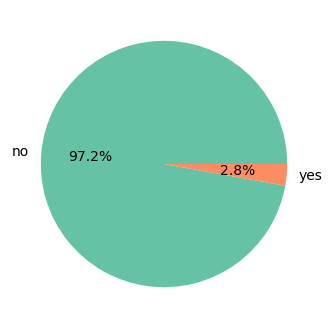

Круговая диаграмма для признака "last_year_violations"


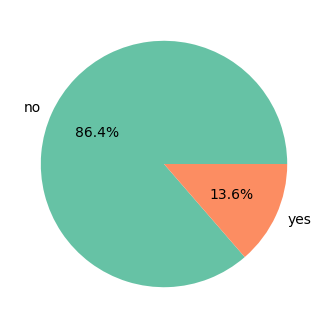

Круговая диаграмма для признака "quit"


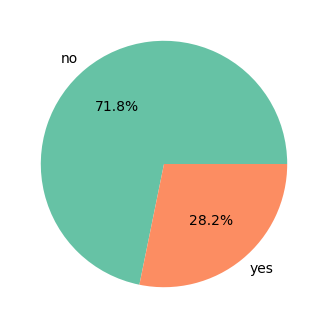

In [33]:
cat_cols.append('quit')
for cat_column in cat_cols:
    print(f'Круговая диаграмма для признака "{cat_column}"')
    plt.rcParams['figure.figsize'] = 4, 4
    x=train_quit.groupby([cat_column])[cat_column].count()
    plt.pie(x=x, labels=x.index, autopct='%1.1f%%', colors=plt.cm.Set2.colors)
    plt.show()

В результате можно отметить следующие особенности данных:

**Длительность работы в компании:**
- `75%` сотрудников имеют стаж `до 6 лет`, в среднем `3-4 года`, наиболее `частые` категории - `1 и 2 года `трудоустройства;
- сотрудники, работающие в компании `более 3 лет`, как правило, `не увольняются` (исходя из данных `train_quit`), при этом есть `исключения` в виде сотрудников со стажем `4-10 лет`, которые в итоге `уволились`;
- распределение значений признака `смещено влево`;

**Оценка руководителя:**
- `средняя` оценка руководителя - `3.47/5`, наиболее `частая` - `4`.
- оценки руководителя у уволившихся и не уволившихся сотрудников `совпадают`;
- присутствует несколько `выбросов` с оценкой `1`;
- значения признака имеют `нормальное распределение`;

**Зарплата:**
- средняя зарплата `~34тыс. руб.`, `минимальная` зарплата в данныз - `12тыс. руб.`, `максимальная` - `~100тыс. руб.`;
- распределение значений признака имеет `нормальный вид`, но со` смещением влево`;
- сотрудники с зарплатой `больше ~50 тыс. руб.`, как правило, `не увольняются`, однако есть `исключения` в виде `ощутимого числа выбросов`;

**Департамент:**
- чуть менее `40%` сотрудников - из `отдела продаж`, чуть более `1/5` - из `ИТ отдела`, остальная доля примерно поровну распределена между `hr отделом`, `отделом закупок` и `маркетинговым отедлом`;

**Должность:**
- `чуть менее половины` сотрудников из выборок имеют должность `junior`, `чуть более 40%` - `middle` и `чуть менее 10%` - `senior`;

**Рабочая загрузка:**
- для `половины` сотрудников из тренировочных выборок загрузка была `средней`, для трети - `низкой`, и для `~17-18%` - `высокой`;

**Повышение в прошлом году:**
- в прошлом году `повышение получили ~3%` сотрудников из тренеровочных выборок;

**Нарушение правил:**
- в прошлом году нарушали правила `~14%` сотрудников;

**Уход из компании:**
- `~30%` сотрудников, представленных в `train_quit` уволилось. 

### Тестовая выборка

Для удобства анализа соеденим признаковое описание тестовой выборки с двумя таргетами:

In [34]:
test_feature_merged = test_features_filled.merge(test_target_job_satisfaction_rate, on='id').merge(test_target_quit, on='id')
test_feature_merged.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate,quit
0,485046,marketing,junior,medium,2,no,no,5,28800,0.79,no
1,686555,hr,junior,medium,1,no,no,4,30000,0.72,no
2,467458,sales,middle,low,5,no,no,4,19200,0.64,no
3,418655,sales,middle,low,6,no,no,4,19200,0.60,no
4,789145,hr,middle,medium,5,no,no,5,40800,0.75,no


Построим гистограмму и ящик с усами для количественным признаков `test_feature_merged`:

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


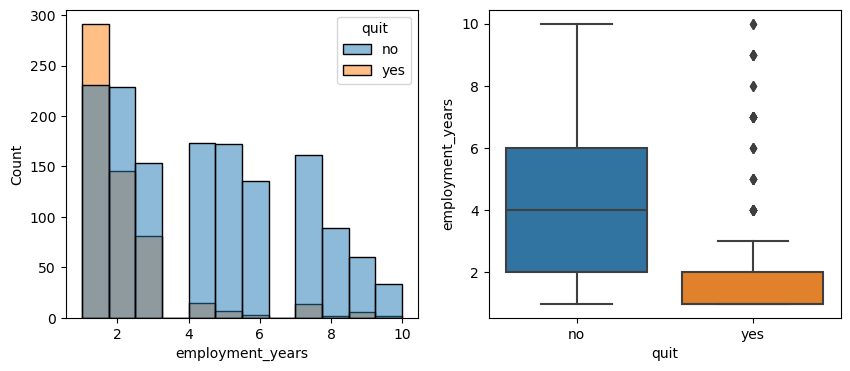

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


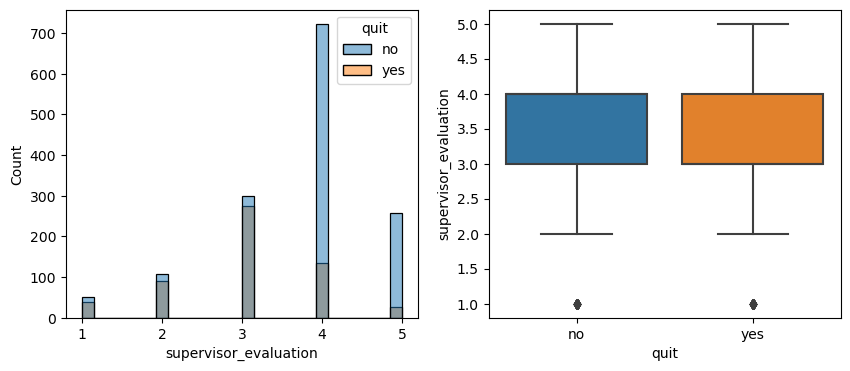

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


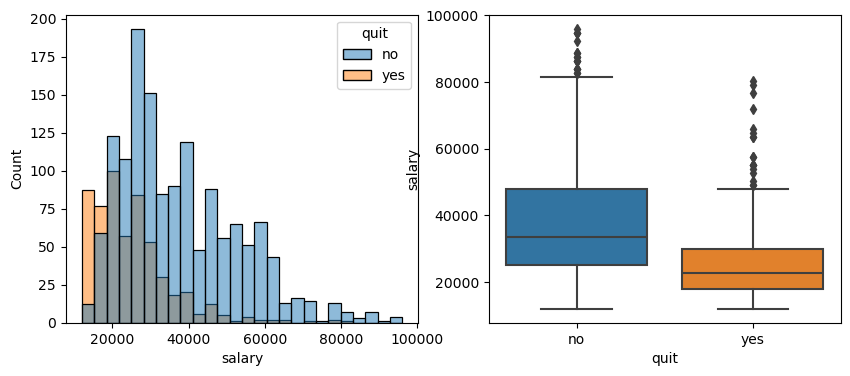

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


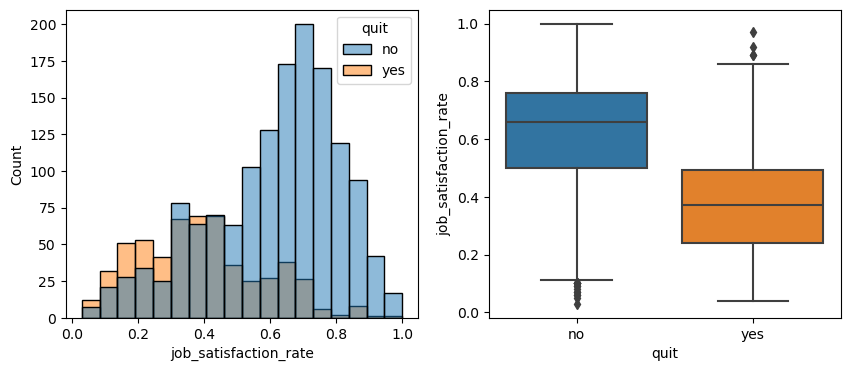

In [35]:
for num_column in num_cols_job_satisfaction_rate:
    plt.rcParams['figure.figsize'] = 10, 4
    plt.subplot(1, 2, 1)
    sns.histplot(data=test_feature_merged, x=num_column, hue='quit')
    plt.subplot(1, 2, 2)
    sns.boxplot(data=test_feature_merged, y=num_column, x='quit')
    plt.show()

Построим круговые диаграммы для категориальных признаков таблицы `test_feature_merged`:

Круговая диаграмма для признака "dept"


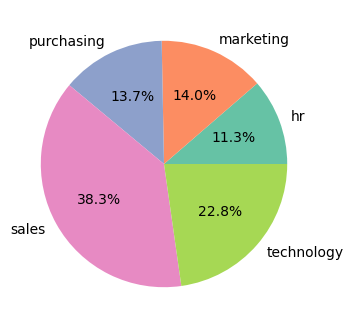

Круговая диаграмма для признака "level"


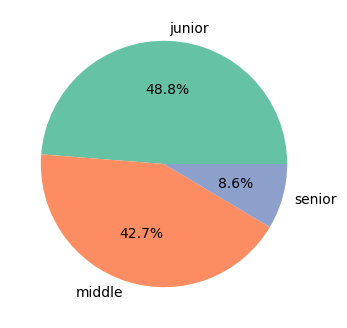

Круговая диаграмма для признака "workload"


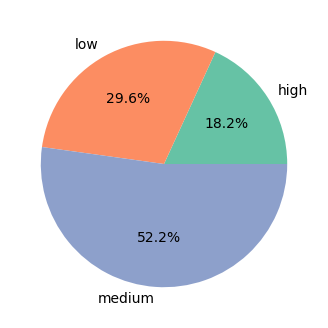

Круговая диаграмма для признака "last_year_promo"


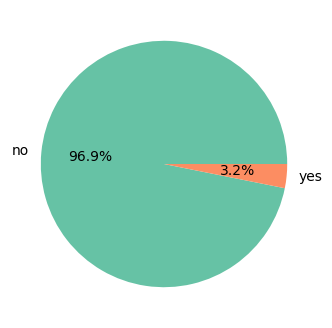

Круговая диаграмма для признака "last_year_violations"


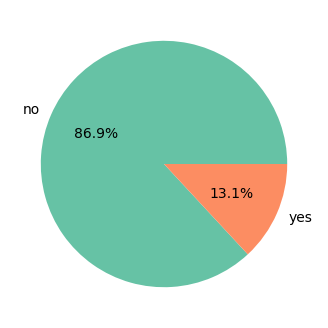

Круговая диаграмма для признака "quit"


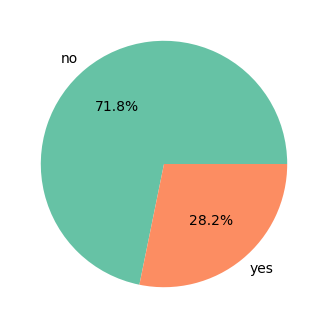

In [36]:
for cat_column in cat_cols:
    print(f'Круговая диаграмма для признака "{cat_column}"')
    plt.rcParams['figure.figsize'] = 4, 4
    x=test_feature_merged.groupby([cat_column])[cat_column].count()
    plt.pie(x=x, labels=x.index, autopct='%1.1f%%', colors=plt.cm.Set2.colors)
    plt.show()

Заметим, что:
- характеристики тестовых данных `такие же`, как и тренировочных;
- удовлетворённость сотрудника работой в компании визуально `влияет` на то, уволится ли сотрудни - сотрудники, которые уходили, заметно более низкий уровень удовлетворенности.

Для точности в выводе, сформулируем нулевую и альтернативную гипотезу и проверим её с помощью статистического теста (t-тест) для двух групп - тех, кто ушел, и тех, кто не ушел:
- **H0 (нулевая гипотеза)**: Средняя удовлетворенность в обеих группах одинакова.
- **H1 (альтернативная гипотеза)**: Средняя удовлетворенность в группе оставшихся больше средней удовлетворенности в группе ушедших.

In [37]:
# Формироыание данных для теста
leave_group = test_feature_merged.query('quit == "yes"').job_satisfaction_rate
stay_group = test_feature_merged.query('quit == "no"').job_satisfaction_rate

# Проведение t-теста
t_statistic, p_value = st.ttest_ind(stay_group, leave_group, alternative='greater')

# Вывод результатов
print(f"Значение t-статистики: {t_statistic}")
print(f"p-значение: {p_value}")

# Проверка значимости p-значения
alpha = 0.05
if p_value < alpha:
    print("Отвергаем нулевую гипотезу в пользу альтернативной")
else:
    print("Не отвергаем нулевую гипотезу")

Значение t-статистики: 23.074784903634534
p-значение: 6.155610332585965e-105
Отвергаем нулевую гипотезу в пользу альтернативной


Статистический тест дал основания отвергнуть нулевую гипотезу в пользу альтернативной, то есть предположить, что средняя удовлетворенность в группе оставшихся больше средней удовлетворенности в группе ушедших. Следовательно, имеются основания говорить, что удовлетворённость сотрудника работой в компании влияет на то, уволится ли он или нет.

### Мультиколлинеарность

Проведём корреляционный анализ признаков, проверим их на мультиколлинеарность. Для этого тепловую карту с корреляцией признаков. Воспользуемся для этого библиотекой phik. Она позволяет работать с разными типами данных, а также учитывать нелинейные зависимости. Построим карту на данных тестовой выборки, так как она включает в себя два целевых признака.

interval columns not set, guessing: ['job_satisfaction_rate']


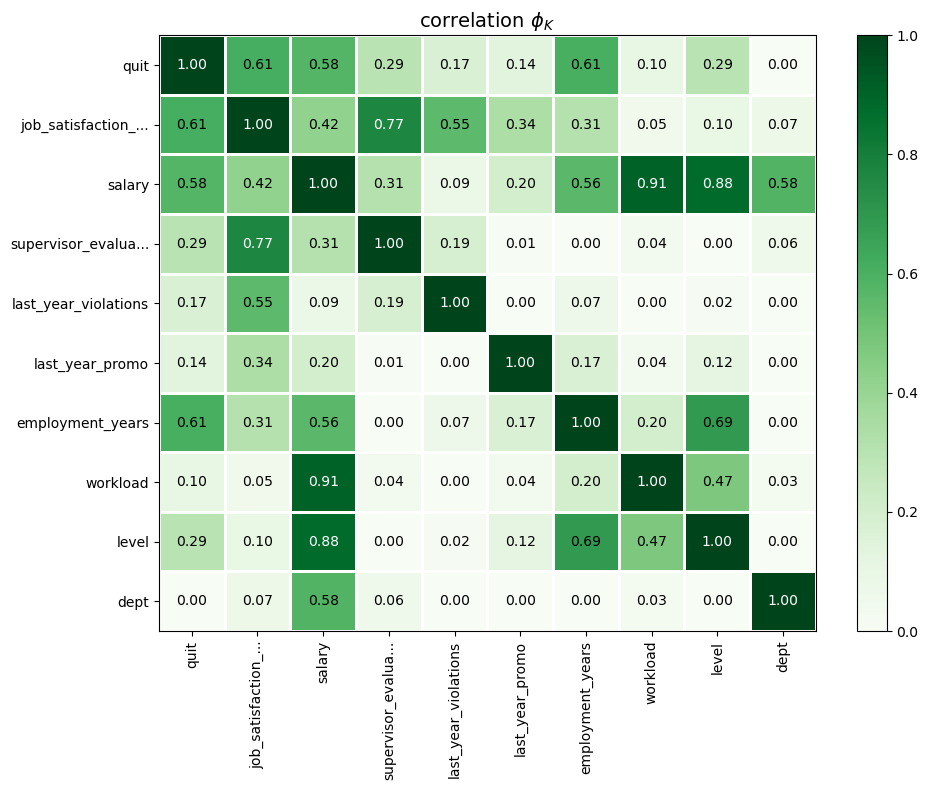

In [38]:
phik_overview = test_feature_merged.drop(['id'], axis=1).phik_matrix()
phik_overview.round(2)

plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1,
                        figsize=(10, 8))
plt.tight_layout()

In [39]:
test_feature_merged.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate,quit
0,485046,marketing,junior,medium,2,no,no,5,28800,0.79,no
1,686555,hr,junior,medium,1,no,no,4,30000,0.72,no
2,467458,sales,middle,low,5,no,no,4,19200,0.64,no
3,418655,sales,middle,low,6,no,no,4,19200,0.60,no
4,789145,hr,middle,medium,5,no,no,5,40800,0.75,no


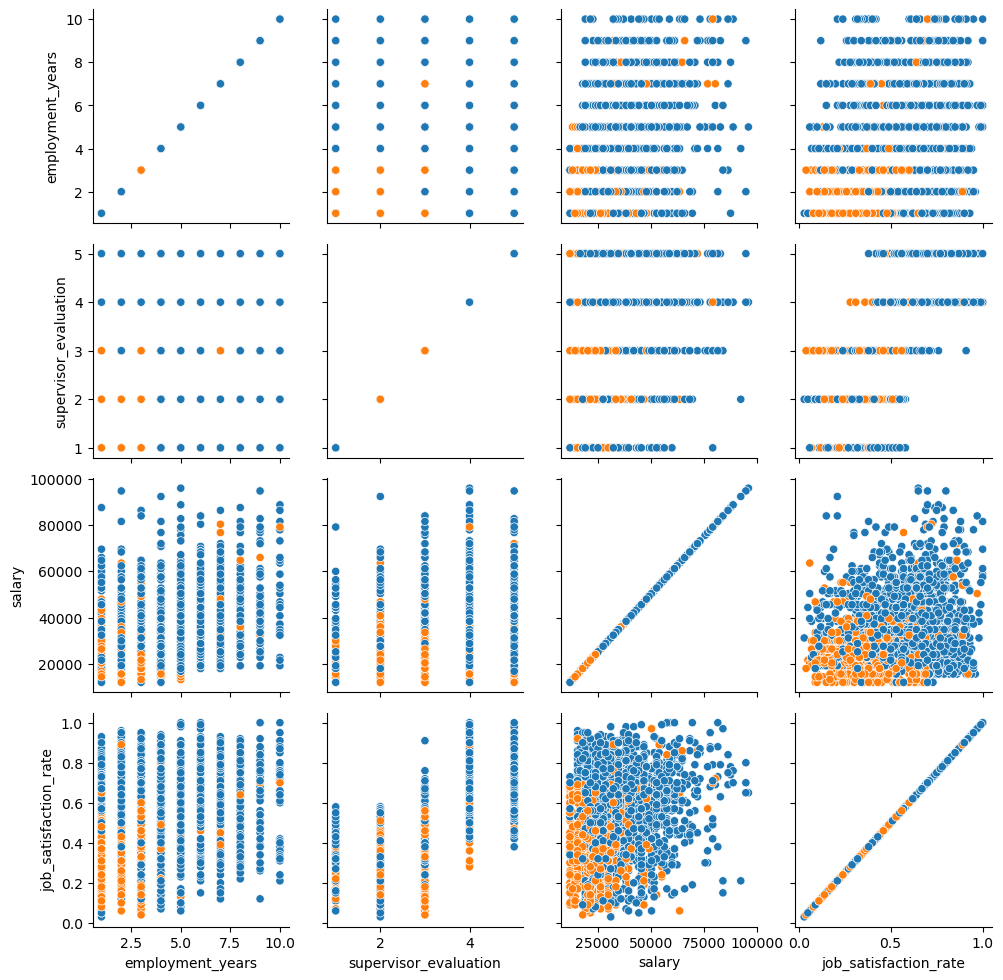

In [40]:
g = sns.PairGrid(test_feature_merged.drop(['id'], axis=1), hue = 'quit')
g.map(sns.scatterplot)
None

Отметим, что:
- `линейной зависимости` между `количественными` признаками `нет`;
- `мультиколлинеарность` в данных `присутствует`, это необходимо `учитывать` при обучении моделей;
- существует `очень сильная` корреляция между
  - зарплатой и рабочей загрузкой (`0.91`),
  - зарплатой и должностью (`0.88`);
- существует `сильная` корреляция между
  - удовлетворенностью сотрудника и оценкой руководителя (`0.77`),
  - удовлетворенностью сотрудника и уходом из компании (`0.61`),
  - уходом из компании и количеством проработанных в компании лет (`0.61`),
  - уходом из компании и зарплатой (`0.58`),
  - зарплатой и количеством проработанных лет (`0.56`),
  - удовлетворенностью сотрудника и наличием нарушений в прошлом году (`0.55`);
- существует `умеренная` корреляция между удовлетворенностью сотрудника и зарплатой (`0.42`).

### Портрет «уволившегося сотрудника»

Проведём дополнительный анализ, чтобы узнать типовые характеристики сотрудников, которые уволились:

#### Департамент

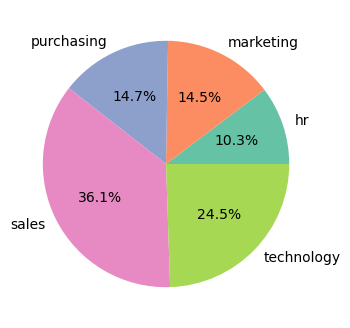

In [41]:
plt.rcParams['figure.figsize'] = 4, 4
x=train_quit[train_quit['quit'] == 'yes'].groupby(['dept'])['dept'].count()
plt.pie(x=x, labels=x.index, autopct='%1.1f%%', colors=plt.cm.Set2.colors)
plt.show()

Посмотрим на долю уволившихся в каждом департаменте:

In [42]:
dept_df = []

for dept in train_quit.dept.unique():
    dept_df.append(list(train_quit[train_quit['dept'] == dept].groupby(['quit'])['quit'].count()))
    
dept_df = pd.DataFrame(dept_df, index=train_quit.dept.unique(), columns=['not quit', 'quit'])
dept_df['% of quit'] = ((dept_df['quit'] / (dept_df['quit'] + dept_df['not quit'])) * 100).map('{:.2f}%'.format)

dept_df.head()

,not quit,quit,% of quit
sales,1031,407,28.30%
purchasing,422,166,28.23%
marketing,419,163,28.01%
technology,652,276,29.74%
hr,348,116,25.00%


Наибольшая доля ушедших в `technology`  и `sales` отделах.

#### Должность

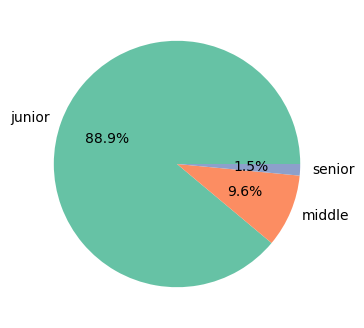

In [43]:
plt.rcParams['figure.figsize'] = 4, 4
x=train_quit[train_quit['quit'] == 'yes'].groupby(['level'])['level'].count()
plt.pie(x=x, labels=x.index, autopct='%1.1f%%', colors=plt.cm.Set2.colors)
plt.show()

In [44]:
level_df = []

for level in train_quit.level.unique():
    level_df.append(list(train_quit[train_quit['level'] == level].groupby(['quit'])['quit'].count()))
    
level_df = pd.DataFrame(level_df, index=train_quit.level.unique(), columns=['not quit', 'quit'])
level_df['% of quit'] = ((level_df['quit'] / (level_df['quit'] + level_df['not quit'])) * 100).map('{:.2f}%'.format)

level_df.head()

,not quit,quit,% of quit
middle,1586,108,6.38%
junior,946,1003,51.46%
senior,340,17,4.76%


Наибольшая доля уходов у `junior` специалистов.

#### Рабочая загрузка

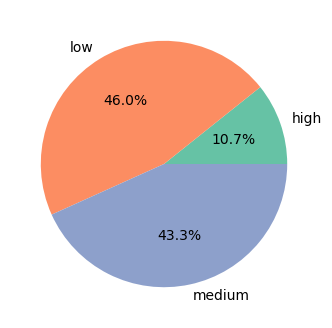

In [45]:
plt.rcParams['figure.figsize'] = 4, 4
x=train_quit[train_quit['quit'] == 'yes'].groupby(['workload'])['workload'].count()
plt.pie(x=x, labels=x.index, autopct='%1.1f%%', colors=plt.cm.Set2.colors)
plt.show()

In [46]:
workload_df = []

for workload in train_quit.workload.unique():
    workload_df.append(list(train_quit[train_quit['workload'] == workload].groupby(['quit'])['quit'].count()))
    
workload_df = pd.DataFrame(workload_df, index=train_quit.workload.unique(), columns=['not quit', 'quit'])
workload_df['% of quit'] = ((workload_df['quit'] / (workload_df['quit'] + workload_df['not quit'])) * 100).map('{:.2f}%'.format)

workload_df.head()

,not quit,quit,% of quit
high,553,121,17.95%
medium,1630,488,23.04%
low,689,519,42.96%


Наибольший процент ухода у сотрдкников с низкой загрузкой.

#### Повышение в прошлом году

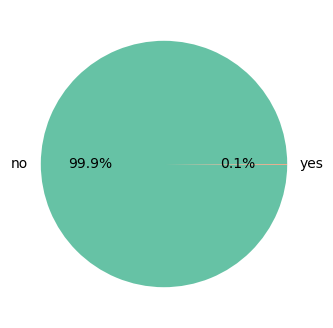

In [47]:
plt.rcParams['figure.figsize'] = 4, 4
x=train_quit[train_quit['quit'] == 'yes'].groupby(['last_year_promo'])['last_year_promo'].count()
plt.pie(x=x, labels=x.index, autopct='%1.1f%%', colors=plt.cm.Set2.colors)
plt.show()

#### Нарушения в прошлом году

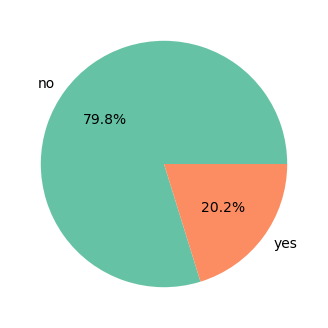

In [48]:
plt.rcParams['figure.figsize'] = 4, 4
x=train_quit[train_quit['quit'] == 'yes'].groupby(['last_year_violations'])['last_year_violations'].count()
plt.pie(x=x, labels=x.index, autopct='%1.1f%%', colors=plt.cm.Set2.colors)
plt.show()

#### Прочее

Сравним средние зарплаты (на основании данных тренировочной выборки):

In [49]:
print(round(train_quit.query('quit == "yes"')['salary'].mean()))
print(round(train_quit.query('quit == "no"')['salary'].mean()))

23885
37702


Сравним уровень удовлетворенности (на основании данных тествой выборки), рассчитаем среднее и построим график:

In [50]:
print(round(test_feature_merged.query('quit == "yes"').job_satisfaction_rate.mean(), 2))
print(round(test_feature_merged.query('quit == "no"').job_satisfaction_rate.mean(), 2))

0.39
0.61


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


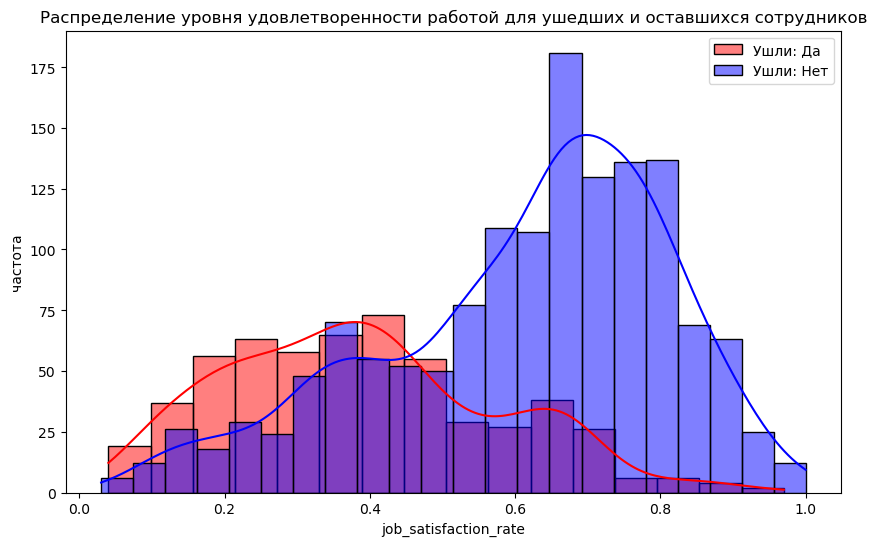

In [51]:
quit_yes_data = test_feature_merged.query('quit == "yes"')['job_satisfaction_rate']
quit_no_data = test_feature_merged.query('quit == "no"')['job_satisfaction_rate']

plt.figure(figsize=(10, 6))
sns.histplot(quit_yes_data, label='Ушли: Да', kde=True, color='red', alpha=0.5)
sns.histplot(quit_no_data, label='Ушли: Нет', kde=True, color='blue', alpha=0.5)

plt.title('Распределение уровня удовлетворенности работой для ушедших и оставшихся сотрудников')
plt.xlabel('job_satisfaction_rate')
plt.ylabel('частота')

plt.legend()

plt.show()

Как видим, у группы ушедших сотрудников уровень удовлетворенности меньше.

На основании проведённого анализа можно составить следующий портрет "уволившегося сотрудника":

- **Стаж работы в компании:** `1-3` года;
- **Зарпалата:** `12-40` тыс. руб. (в среднем `~24 тыс. руб.` против `~38 тыс. руб.` у неуволившихся);
- **Департамент:** `ИТ` или `продажи`;
- **Должность:** `junior`;
- **Загрузка:** `низкая` (реже - `средняя`);
- **Повышение в прошлом году:** `не было`;
- **Нарушения в прошлом году:** в `8 случаев из 10` - нет, однако вероятность `выше`, чем у неуволившихся;
- **Удовлетворенность работой:** `~0.4/1.0` (против `~0.6/1.0` у неуволившихся).

<div class="alert"; style="border-left: 7px solid pink">

**Мини-вывод**
- характеристики тренировочных и тестовых данных идентичны;
- типовой уволившийся сотрудник работает в компании недолго, получает немного, имеет начальную должность, работает в продажах или ИТ, имеет низкую удовлетворенность работой в компании, может иногда нарушать правила компании.
</div>

## Задача №1 <a id='4'> <a>

### Подготовка данных к обучнию <a id='5'> <a>

In [52]:
train_job_satisfaction_rate_filled.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.2


In [53]:
test_features_filled.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


In [54]:
test_features_filled.level.value_counts()

level
junior    975
middle    854
senior    171
Name: count, dtype: int64

In [55]:
test_target_job_satisfaction_rate.head()

,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


Удалим дубликаты, которые были ранее обнаружены:

In [56]:
#train_job_satisfaction_rate_filled
duplicated_ids = list(train_job_satisfaction_rate_filled[train_job_satisfaction_rate_filled.drop(
    ['id'], axis=1).duplicated()].id)
train_job_satisfaction_rate_filtered = train_job_satisfaction_rate_filled.query(
    'id not in @duplicated_ids').reset_index().drop(['index'], axis=1)

#train_quit
duplicated_ids = list(train_quit[train_quit.drop(
    ['id'], axis=1).duplicated()].id)
train_quit_filtered = train_quit.query(
    'id not in @duplicated_ids').reset_index().drop(['index'], axis=1)

#test_feature_merged
duplicated_ids = list(test_feature_merged[test_feature_merged.drop(
    ['id'], axis=1).duplicated()].id)
test_feature_merged_filtered = test_feature_merged.query(
    'id not in @duplicated_ids').reset_index().drop(['index'], axis=1)

Подготовку признаков выполним в пайплайне:

Обозначим, какие данные требуют масштабирования, а какие — кодирования:

In [57]:
ord_columns = ['level', 'workload']

ohe_columns = ['dept', 'last_year_promo', 'last_year_violations']

num_columns = ['employment_years', 'supervisor_evaluation', 'salary']

In [58]:
ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe', 
            OneHotEncoder(drop='first', handle_unknown='ignore')
        )
    ]
) 

ord_pipe = Pipeline([('ord', OrdinalEncoder(
    categories=[['junior', 'middle', 'senior'], ['low', 'medium', 'high']],
    handle_unknown='use_encoded_value',
    unknown_value=np.nan
))])

Объеденим этапы по кодированию и масштабированию:

In [59]:
data_preprocessor=ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', StandardScaler(), num_columns)
    ],
    remainder='passthrough'
)

Создадим итоговый пайплайн для обучения модели:

In [60]:
RANDOM_STATE = 42

pipe_final=Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
    ]
)

Создадим метрику `SMAPE` и переберем разные методы масштабирования и расширим пайплайн:

In [61]:
def smape_score(y_test, y_pred):
    y_true = np.array(y_test)
    y_pred = np.array(y_pred)
    return round(sum(abs(y_test - y_pred) / ((abs(y_test) + abs(y_pred))/2)) * 100 / len(y_test), 2)

scorer = make_scorer(smape_score, greater_is_better=False) 

param_grid = {
    'preprocessor__num': [StandardScaler(), MinMaxScaler()],
    'models': [
        LinearRegression(),
        DecisionTreeRegressor()
    ]
}

grid = GridSearchCV(
    pipe_final,
    param_grid=param_grid,
    cv = 5,
    scoring = scorer,
    n_jobs=-1
)

In [62]:
X_train = train_job_satisfaction_rate_filtered.drop(['job_satisfaction_rate', 'id'], axis=1)
y_train = train_job_satisfaction_rate_filtered['job_satisfaction_rate']

X_test = test_feature_merged_filtered.drop(['id', 'quit', 'job_satisfaction_rate'], axis=1)
y_test = test_feature_merged_filtered['job_satisfaction_rate']

### Обучение моделей <a id='6'> <a>

In [63]:
grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         Pipeline(steps=[('simpleImputer_ohe',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ohe',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore'))]),
                                                                         ['dept',
                                                                          'last_year_promo',
                                                                          'last_year_violations']),
                                                                        ('ord',
                                                                         Pipeline(steps=[('ord',
                                                                                          Ordina...
                                                                          'workload']),
                                                                        ('num',
                                                                         StandardScaler(),
                                                                         ['employment_years',
                                                                          'supervisor_evaluation',
                                                                          'salary'])])),
                                       ('models',
                                        DecisionTreeClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'models': [LinearRegression(),
                                    DecisionTreeRegressor()],
                         'preprocessor__num': [StandardScaler(),
                                               MinMaxScaler()]},
             scoring=make_scorer(smape_score, greater_is_better=False, response_method='predict'))

In [64]:
display(pd.DataFrame(grid.cv_results_).sort_values(by='rank_test_score').drop(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time','std_test_score', 'split0_test_score', 'split1_test_score', 'split2_test_score',
       'split3_test_score', 'split4_test_score'], axis=1))

,param_models,param_preprocessor__num,params,mean_test_score,rank_test_score
3,DecisionTreeRegressor(),MinMaxScaler(),"{'models': DecisionTreeRegressor(), 'preproces...",-15.872,1
2,DecisionTreeRegressor(),StandardScaler(),"{'models': DecisionTreeRegressor(), 'preproces...",-15.962,2
0,LinearRegression(),StandardScaler(),"{'models': LinearRegression(), 'preprocessor__...",-24.992,3
1,LinearRegression(),MinMaxScaler(),"{'models': LinearRegression(), 'preprocessor__...",-24.992,3


Лучшая модель - DecisionTreeRegressor (стандартизация StandardScaler()). Среднее начение SMAPE в результате кросс-валидации равняется `15.872`. В целом, можно говорить о неплохом качестве модели. 2-я по качеству модель тоже `DecisionTreeRegressor()`, но с масштабированием `MinMaxScaler()`. Модель `LinearRegression()` справляется с предсказыванием `значительно хуже`. Это может быть связано с тем, что признаки не коррелируют линейно с таргетом.

Подберём гиперпараметры для модели `DecisionTreeRegressor`:

In [65]:
param_distributions = {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],
        'models__min_samples_leaf': range(1, 11),
        'models__max_depth': range(2, 11),
        'models__max_features': ['auto', 'sqrt', 'log2', None]
    }

In [66]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_distributions=param_distributions, 
    scoring=scorer, 
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train) 

/opt/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
15 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
8 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.11/site-packages/sklearn/pipeline.py", line 473, in fit
    self._final_estimator.

RandomizedSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore'))]),
                                                                               ['dept',
                                                                                'last_year_promo',
                                                                                'last_year_violations']),
                                                                              ('ord',
                                                                               Pipeline(steps=[('ord',
                                                                                                Ordin...
                   param_distributions={'models': [DecisionTreeRegressor(random_state=42)],
                                        'models__max_depth': range(2, 11),
                                        'models__max_features': ['auto', 'sqrt',
                                                                 'log2', None],
                                        'models__min_samples_leaf': range(1, 11),
                                        'preprocessor__num': [StandardScaler(),
                                                              MinMaxScaler(),
                                                              'passthrough']},
                   random_state=42,
                   scoring=make_scorer(smape_score, greater_is_better=False, response_method='predict'))

In [67]:
pd.DataFrame(randomized_search.cv_results_).sort_values(by='rank_test_score').drop(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time','std_test_score', 'split0_test_score', 'split1_test_score', 'split2_test_score',
       'split3_test_score', 'split4_test_score'], axis=1).head()

,param_preprocessor__num,param_models__min_samples_leaf,param_models__max_features,param_models__max_depth,param_models,params,mean_test_score,rank_test_score
6,MinMaxScaler(),1,sqrt,9,DecisionTreeRegressor(random_state=42),"{'preprocessor__num': MinMaxScaler(), 'models_...",-19.334,1
8,MinMaxScaler(),7,sqrt,8,DecisionTreeRegressor(random_state=42),"{'preprocessor__num': MinMaxScaler(), 'models_...",-19.670,2
1,StandardScaler(),9,log2,10,DecisionTreeRegressor(random_state=42),"{'preprocessor__num': StandardScaler(), 'model...",-19.794,3
3,MinMaxScaler(),6,None,5,DecisionTreeRegressor(random_state=42),"{'preprocessor__num': MinMaxScaler(), 'models_...",-20.306,4
4,StandardScaler(),1,None,4,DecisionTreeRegressor(random_state=42),"{'preprocessor__num': StandardScaler(), 'model...",-21.534,5


Подбор гиперпараметров не выявил более оптимальной модели.

Проведем итоговую оценку лучшей модели на тестовой выборке:

In [68]:
X_train_preprocessed = pd.DataFrame(data_preprocessor.fit_transform(X_train))
X_test_preprocessed = pd.DataFrame(data_preprocessor.fit_transform(X_test))

best_model = DecisionTreeRegressor(random_state=RANDOM_STATE)

best_model.fit(X_train_preprocessed, y_train)

y_pred = best_model.predict(X_test_preprocessed)

In [69]:
print('Значение SMAPE лучшей модели (DecisionTreeRegressor) задачи №1 на тестовой выборке:', smape_score(y_test, y_pred))

Значение SMAPE лучшей модели (DecisionTreeRegressor) задачи №1 на тестовой выборке: 14.84


### Промежуточные выводы <a id='7'> <a>

<div class="alert"; style="border-left: 7px solid pink">
    
- DecisionTreeRegressor со StandardScaler лучший (SMAPE = 15.872 при кросс-валидации), что указывает на неплохое качество модели. Вторая по качеству модель также DecisionTreeRegressor, но с MinMaxScaler. LinearRegression значительно менее эффективна, возможно из-за отсутствия линейной корреляции между признаками и целевой переменной.
- Значение метрики SMAPE лучшей модели на тестовой выборке = `14.85` (<15), следовательно можем говорить об `успешности` модели.
    
</div>

## Задача №2 <a id='8'> <a>

### Подготовка данных к обучнию <a id='9'> <a>

Заменим значения целевого признака `quit` на `1`, если сотдруник `ушел` из компании, и `0` если он `не ушел`.

In [70]:
X_test_2 = test_feature_merged_filtered.drop(['id', 'quit'], axis=1)

label_encoder = LabelEncoder()

y_test_2 = test_feature_merged_filtered['quit']
y_test_2 = label_encoder.fit_transform(y_test_2)

train_quit_filtered.quit = label_encoder.transform(train_quit_filtered.quit)

Для начала добавим в данные новый признак (`job_satisfaction_rate`), используя лучшую модель из прошлой задачи.

In [71]:
X_train_predict = train_quit_filtered.drop(['quit'], axis=1)

grid.predict(X_train_predict)

train_quit_filtered['job_satisfaction_rate'] = grid.predict(X_train_predict)

train_quit_filtered['job_satisfaction_rate'] = train_quit_filtered['job_satisfaction_rate'].apply(lambda x: round(x, 2))

train_quit_filtered.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
0,723290,sales,middle,high,2,no,no,4,54000,0,0.60
1,814010,sales,junior,medium,2,no,no,4,27600,0,0.85
2,155091,purchasing,middle,medium,5,no,no,1,37200,0,0.38
3,257132,sales,junior,medium,2,no,yes,3,24000,1,0.38
4,910140,marketing,junior,medium,2,no,no,5,25200,0,0.69


In [72]:
X_train_quit = train_quit_filtered.drop(['quit'], axis=1)
y_train_quit = train_quit_filtered['quit']

In [73]:
pipe_final_2=Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
    ]
)

param_grid_2 = {
    'preprocessor__num': [StandardScaler(), MinMaxScaler()],
    'models': [
        DecisionTreeClassifier(random_state=RANDOM_STATE),
        KNeighborsClassifier(),
        SVC(random_state=RANDOM_STATE, probability=True),
        LogisticRegression(random_state=RANDOM_STATE)
    ]
}

grid_2 = GridSearchCV(
    pipe_final,
    param_grid=param_grid_2,
    cv = 5,
    scoring = 'roc_auc',
    n_jobs=1
)

In [74]:
grid_2.fit(X_train_quit, y_train_quit)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_ite

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         Pipeline(steps=[('simpleImputer_ohe',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ohe',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore'))]),
                                                                         ['dept',
                                                                          'last_year_promo',
                                                                          'last_year_violations']),
                                                                        ('ord',
                                                                         Pipeline(steps=[('ord',
                                                                                          Ordina...
                                                                         ['employment_years',
                                                                          'supervisor_evaluation',
                                                                          'salary'])])),
                                       ('models',
                                        DecisionTreeClassifier(random_state=42))]),
             n_jobs=1,
             param_grid={'models': [DecisionTreeClassifier(random_state=42),
                                    KNeighborsClassifier(),
                                    SVC(probability=True, random_state=42),
                                    LogisticRegression(random_state=42)],
                         'preprocessor__num': [StandardScaler(),
                                               MinMaxScaler()]},
             scoring='roc_auc')

In [75]:
display(pd.DataFrame(grid_2.cv_results_).sort_values(by='rank_test_score').drop(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time','std_test_score', 'split0_test_score', 'split1_test_score', 'split2_test_score',
       'split3_test_score', 'split4_test_score'], axis=1))

,param_models,param_preprocessor__num,params,mean_test_score,rank_test_score
6,LogisticRegression(random_state=42),StandardScaler(),{'models': LogisticRegression(random_state=42)...,0.896346,1
7,LogisticRegression(random_state=42),MinMaxScaler(),{'models': LogisticRegression(random_state=42)...,0.874751,2
0,DecisionTreeClassifier(random_state=42),StandardScaler(),{'models': DecisionTreeClassifier(random_state...,0.769114,3
1,DecisionTreeClassifier(random_state=42),MinMaxScaler(),{'models': DecisionTreeClassifier(random_state...,0.768856,4
2,KNeighborsClassifier(),StandardScaler(),"{'models': KNeighborsClassifier(), 'preprocess...",0.488873,5
3,KNeighborsClassifier(),MinMaxScaler(),"{'models': KNeighborsClassifier(), 'preprocess...",0.488873,5
4,"SVC(probability=True, random_state=42)",StandardScaler(),"{'models': SVC(probability=True, random_state=...",0.485397,7
5,"SVC(probability=True, random_state=42)",MinMaxScaler(),"{'models': SVC(probability=True, random_state=...",0.471333,8


Лучшие модели по результатам кросс-валидации - `LogisticRegression` (`1-е` место с StandardScaler с `mean_test_score=0.8966`,`2-е` с MinMaxScaler с `mean_test_score=0.8774`) и `DecisionTreeClassifier` (1-е место с MinMaxScaler с `mean_test_score=0.7732`, 2-е с StandardScaler с `mean_test_score=0.77303`).

Подберём для вышеупомянутых двух моделей гиперпараметры, используя `RandomizedSearchCV`:

In [76]:
param_distributions = [
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 11),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'] 
    },
    
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE)],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],
        'models__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
        'models__penalty': ['l2', None],
        'models__C':[0.1,0.4,0.5,0.6,0.7,0.8,1,2,5,10,100]
    }
]

### Обучение моделей <a id='10'> <a>

In [77]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_distributions=param_distributions, 
    scoring='roc_auc', 
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train_quit, y_train_quit) 

/opt/anaconda3/lib/python3.11/site-packages/scipy/optimize/_linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/anaconda3/lib/python3.11/site-packages/scipy/optimize/_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/anaconda3/lib/python3.11/site-packages/scipy/optimize/_linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/anaconda3/lib/python3.11/site-packages/scipy/optimize/_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/anaconda3/lib/python3.11/site-packages/scipy/optimize/_linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn(

RandomizedSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore'))]),
                                                                               ['dept',
                                                                                'last_year_promo',
                                                                                'last_year_violations']),
                                                                              ('ord',
                                                                               Pipeline(steps=[('ord',
                                                                                                Ordin...
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']},
                                        {'models': [LogisticRegression(random_state=42)],
                                         'models__C': [0.1, 0.4, 0.5, 0.6, 0.7,
                                                       0.8, 1, 2, 5, 10, 100],
                                         'models__penalty': ['l2', None],
                                         'models__solver': ['newton-cg',
                                                            'lbfgs',
                                                            'liblinear', 'sag',
                                                            'saga'],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']}],
                   random_state=42, scoring='roc_auc')

In [78]:
print('Метрика roc_auc для лучшей модели:\n', randomized_search.best_score_)

Метрика roc_auc для лучшей модели:
 0.902721277822389


In [79]:
pd.DataFrame(randomized_search.cv_results_).sort_values(by='rank_test_score').drop(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time','std_test_score', 'split0_test_score', 'split1_test_score', 'split2_test_score',
       'split3_test_score', 'split4_test_score'], axis=1).head(5)

,param_preprocessor__num,param_models__solver,param_models__penalty,param_models__C,param_models,param_models__max_depth,params,mean_test_score,rank_test_score
0,StandardScaler(),newton-cg,None,1.0,LogisticRegression(random_state=42),NaN,"{'preprocessor__num': StandardScaler(), 'model...",0.902721,1
1,StandardScaler(),newton-cg,None,0.1,LogisticRegression(random_state=42),NaN,"{'preprocessor__num': StandardScaler(), 'model...",0.902721,1
7,StandardScaler(),newton-cg,l2,0.4,LogisticRegression(random_state=42),NaN,"{'preprocessor__num': StandardScaler(), 'model...",0.902181,3
3,StandardScaler(),lbfgs,l2,10.0,LogisticRegression(random_state=42),NaN,"{'preprocessor__num': StandardScaler(), 'model...",0.897186,4
6,StandardScaler(),NaN,NaN,NaN,DecisionTreeClassifier(random_state=42),7.0,"{'preprocessor__num': StandardScaler(), 'model...",0.870664,5


Лучше всего справилась модель `LogisticRegression()` с гиперпараметром `solver=newton-cg`, `C=100`, `penalty=None` и масштабированием `StandardScaler()`: значение `roc_auc` - `0.903`.

Отберём признаки в попытки улучшить метрику. Уберём признак `job_satisfaction_rate`:

In [80]:
X_test_3 = test_feature_merged_filtered.drop(['id', 'quit', 'job_satisfaction_rate'], axis=1)

X_train_3 = train_quit_filtered.drop(['id', 'quit', 'job_satisfaction_rate'], axis=1)
y_train_3 = train_quit_filtered['quit']

In [81]:
randomized_search.fit(X_train_3, y_train_3)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=No

RandomizedSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore'))]),
                                                                               ['dept',
                                                                                'last_year_promo',
                                                                                'last_year_violations']),
                                                                              ('ord',
                                                                               Pipeline(steps=[('ord',
                                                                                                Ordin...
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']},
                                        {'models': [LogisticRegression(random_state=42)],
                                         'models__C': [0.1, 0.4, 0.5, 0.6, 0.7,
                                                       0.8, 1, 2, 5, 10, 100],
                                         'models__penalty': ['l2', None],
                                         'models__solver': ['newton-cg',
                                                            'lbfgs',
                                                            'liblinear', 'sag',
                                                            'saga'],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']}],
                   random_state=42, scoring='roc_auc')

In [82]:
print('Метрика roc_auc для лучшей модели:\n', randomized_search.best_score_)
pd.DataFrame(randomized_search.cv_results_).sort_values(by='rank_test_score').drop(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time','std_test_score', 'split0_test_score', 'split1_test_score', 'split2_test_score',
       'split3_test_score', 'split4_test_score'], axis=1).head(3)

Метрика roc_auc для лучшей модели:
 0.901086946412604


,param_preprocessor__num,param_models__solver,param_models__penalty,param_models__C,param_models,param_models__max_depth,params,mean_test_score,rank_test_score
2,StandardScaler(),sag,None,5.0,LogisticRegression(random_state=42),NaN,"{'preprocessor__num': StandardScaler(), 'model...",0.901087,1
0,StandardScaler(),newton-cg,None,1.0,LogisticRegression(random_state=42),NaN,"{'preprocessor__num': StandardScaler(), 'model...",0.901043,2
1,StandardScaler(),newton-cg,None,0.1,LogisticRegression(random_state=42),NaN,"{'preprocessor__num': StandardScaler(), 'model...",0.901043,2


Как видим, качество модели немного улучшилось. Подберём другие параметры.

Ранее мы выяснили, что существует сильная корреляция между удовлетворенностью сотрудника и оценкой руководителя (0.77). Создадим интегральный показатель путем взвешенной комбинации таких факторов, как удовлетворенность сотрудника и оценка руководства. Вычислим его по 
этой формуле:
- `overall_satisfaction_rate=0.6×job_satisfaction_rate+0.4×supervisor_evaluation`

In [83]:
X_train_quit['overall_satisfaction_rate'] = 0.6 * X_train_quit['job_satisfaction_rate'] + 0.4 * X_train_quit['supervisor_evaluation']
X_train_quit = X_train_quit.drop(['supervisor_evaluation', 'job_satisfaction_rate'], axis=1)
X_train_quit.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,salary,overall_satisfaction_rate
0,723290,sales,middle,high,2,no,no,54000,1.960
1,814010,sales,junior,medium,2,no,no,27600,2.110
2,155091,purchasing,middle,medium,5,no,no,37200,0.628
3,257132,sales,junior,medium,2,no,yes,24000,1.428
4,910140,marketing,junior,medium,2,no,no,25200,2.414


In [84]:
X_test_2['overall_satisfaction_rate'] = 0.6 * X_test_2['job_satisfaction_rate'] + 0.4 * X_test_2['supervisor_evaluation']
X_test_3 = X_test_2.drop(['supervisor_evaluation', 'job_satisfaction_rate'], axis=1)
X_test_3.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,salary,overall_satisfaction_rate
0,marketing,junior,medium,2,no,no,28800,2.474
1,hr,junior,medium,1,no,no,30000,2.032
2,sales,middle,low,5,no,no,19200,1.984
3,sales,middle,low,6,no,no,19200,1.96
4,hr,middle,medium,5,no,no,40800,2.45


In [85]:
num_columns_2 = ['employment_years', 'salary']

data_preprocessor_2=ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', StandardScaler(), num_columns_2)
    ],
    remainder='passthrough'
)

In [86]:
pipe_final_3=Pipeline(
    [
        ('preprocessor', data_preprocessor_2),
        ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
    ]
)

param_grid_3 = {
    'preprocessor__num': [StandardScaler(), MinMaxScaler()],
    'models': [
        DecisionTreeClassifier(random_state=RANDOM_STATE),
        KNeighborsClassifier(),
        SVC(random_state=RANDOM_STATE, probability=True),
        LogisticRegression(random_state=RANDOM_STATE)
    ]
}

In [87]:
param_distributions = [
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 11),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'] 
    },
    
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE)],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],
        'models__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
        'models__penalty': ['l2', None],
        'models__C':[0.1,0.4,0.5,0.6,0.7,0.8,1,2,5,10,100]
    }
]

randomized_search_2 = RandomizedSearchCV(
    pipe_final_3, 
    param_distributions=param_distributions, 
    scoring='roc_auc', 
    random_state=RANDOM_STATE,
    n_jobs=-1
) 

Обучим модель:

In [88]:
randomized_search_2.fit(X_train_quit, y_train_3)

/opt/anaconda3/lib/python3.11/site-packages/scipy/optimize/_linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/anaconda3/lib/python3.11/site-packages/scipy/optimize/_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/anaconda3/lib/python3.11/site-packages/scipy/optimize/_linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/anaconda3/lib/python3.11/site-packages/scipy/optimize/_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/anaconda3/lib/python3.11/site-packages/scipy/optimize/_linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn(

RandomizedSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore'))]),
                                                                               ['dept',
                                                                                'last_year_promo',
                                                                                'last_year_violations']),
                                                                              ('ord',
                                                                               Pipeline(steps=[('ord',
                                                                                                Ordin...
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']},
                                        {'models': [LogisticRegression(random_state=42)],
                                         'models__C': [0.1, 0.4, 0.5, 0.6, 0.7,
                                                       0.8, 1, 2, 5, 10, 100],
                                         'models__penalty': ['l2', None],
                                         'models__solver': ['newton-cg',
                                                            'lbfgs',
                                                            'liblinear', 'sag',
                                                            'saga'],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']}],
                   random_state=42, scoring='roc_auc')

In [89]:
print('Метрика roc_auc для лучшей модели:\n', randomized_search_2.best_score_)
pd.DataFrame(randomized_search_2.cv_results_).sort_values(by='rank_test_score').drop(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time','std_test_score', 'split0_test_score', 'split1_test_score', 'split2_test_score',
       'split3_test_score', 'split4_test_score'], axis=1).head(3)

Метрика roc_auc для лучшей модели:
 0.9020875421494828


,param_preprocessor__num,param_models__solver,param_models__penalty,param_models__C,param_models,param_models__max_depth,params,mean_test_score,rank_test_score
0,StandardScaler(),newton-cg,None,1.0,LogisticRegression(random_state=42),NaN,"{'preprocessor__num': StandardScaler(), 'model...",0.902088,1
1,StandardScaler(),newton-cg,None,0.1,LogisticRegression(random_state=42),NaN,"{'preprocessor__num': StandardScaler(), 'model...",0.902088,1
7,StandardScaler(),newton-cg,l2,0.4,LogisticRegression(random_state=42),NaN,"{'preprocessor__num': StandardScaler(), 'model...",0.901475,3


Качество модели не стало лучше.

Попробуем убрать из признакового описание признак `workload`, который сильно коррелирует с зарплатой:

In [90]:
ord_columns_2 = ['level']

ohe_pipe_3 = Pipeline(
    [
        (
            'simpleImputer_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe', 
            OneHotEncoder(drop='first', handle_unknown='ignore')
        )
    ]
) 

ord_pipe = Pipeline([('ord', OrdinalEncoder(
    categories=[['junior', 'middle', 'senior']],
    handle_unknown='use_encoded_value',
    unknown_value=np.nan
))])

In [91]:
data_preprocessor_3=ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns_2),
        ('num', StandardScaler(), num_columns)
    ],
    remainder='passthrough'
)

In [92]:
pipe_final_4=Pipeline(
    [
        ('preprocessor', data_preprocessor_3),
        ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
    ]
)

param_grid_4 = {
    'preprocessor__num': [StandardScaler(), MinMaxScaler()],
    'models': [
        DecisionTreeClassifier(random_state=RANDOM_STATE),
        KNeighborsClassifier(),
        SVC(random_state=RANDOM_STATE, probability=True),
        LogisticRegression(random_state=RANDOM_STATE)
    ]
}

randomized_search_3 = RandomizedSearchCV(
    pipe_final_4, 
    param_distributions=param_distributions, 
    scoring='roc_auc', 
    random_state=RANDOM_STATE,
    n_jobs=-1
)

In [93]:
X_test_4 = test_feature_merged_filtered.drop(['id', 'quit', 'workload'], axis=1)

X_train_4 = train_quit_filtered.drop(['id', 'quit', 'workload'], axis=1)
y_train_3 = train_quit_filtered['quit']

In [94]:
randomized_search_3.fit(X_train_4, y_train_3)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=No

RandomizedSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore'))]),
                                                                               ['dept',
                                                                                'last_year_promo',
                                                                                'last_year_violations']),
                                                                              ('ord',
                                                                               Pipeline(steps=[('ord',
                                                                                                Ordin...
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']},
                                        {'models': [LogisticRegression(random_state=42)],
                                         'models__C': [0.1, 0.4, 0.5, 0.6, 0.7,
                                                       0.8, 1, 2, 5, 10, 100],
                                         'models__penalty': ['l2', None],
                                         'models__solver': ['newton-cg',
                                                            'lbfgs',
                                                            'liblinear', 'sag',
                                                            'saga'],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']}],
                   random_state=42, scoring='roc_auc')

In [95]:
print('Метрика roc_auc для лучшей модели:\n', randomized_search_3.best_score_)
pd.DataFrame(randomized_search_3.cv_results_).sort_values(by='rank_test_score').drop(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time','std_test_score', 'split0_test_score', 'split1_test_score', 'split2_test_score',
       'split3_test_score', 'split4_test_score'], axis=1).head(3)

Метрика roc_auc для лучшей модели:
 0.9024451324699493


,param_preprocessor__num,param_models__solver,param_models__penalty,param_models__C,param_models,param_models__max_depth,params,mean_test_score,rank_test_score
2,StandardScaler(),sag,None,5.0,LogisticRegression(random_state=42),NaN,"{'preprocessor__num': StandardScaler(), 'model...",0.902445,1
0,StandardScaler(),newton-cg,None,1.0,LogisticRegression(random_state=42),NaN,"{'preprocessor__num': StandardScaler(), 'model...",0.902433,2
1,StandardScaler(),newton-cg,None,0.1,LogisticRegression(random_state=42),NaN,"{'preprocessor__num': StandardScaler(), 'model...",0.902433,2


Как видим, качество стала чуть лучше по сравнению с предыдущей моделью, но хуже чем изначальная. Теперь же попробруем убрать сразу несколько признаков, которые слабо коррлеирует с уходом из компании в соответветствии с проведенным ранее корреляционным анализом. А именно исключим из модели следующие признаки: `last_year_promo`, `last_year_violations`, `dept`.

In [96]:
ord_pipe = Pipeline([('ord', OrdinalEncoder(
    categories=[['junior', 'middle', 'senior'], ['low', 'medium', 'high']],
    handle_unknown='use_encoded_value',
    unknown_value=np.nan
))])

In [97]:
data_preprocessor_4=ColumnTransformer(
    [
        ('ord', ord_pipe, ord_columns),
        ('num', StandardScaler(), num_columns)
    ],
    remainder='passthrough'
)

In [98]:
pipe_final_5=Pipeline(
    [
        ('preprocessor', data_preprocessor_4),
        ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
    ]
)

param_grid_5 = {
    'preprocessor__num': [StandardScaler(), MinMaxScaler()],
    'models': [
        DecisionTreeClassifier(random_state=RANDOM_STATE),
        KNeighborsClassifier(),
        SVC(random_state=RANDOM_STATE, probability=True),
        LogisticRegression(random_state=RANDOM_STATE)
    ]
}

randomized_search_4 = RandomizedSearchCV(
    pipe_final_5, 
    param_distributions=param_distributions, 
    scoring='roc_auc', 
    random_state=RANDOM_STATE,
    n_jobs=-1
)

In [99]:
X_test_5 = test_feature_merged_filtered.drop(['id', 'quit', 'last_year_promo', 'last_year_violations', 'dept'], axis=1)

X_train_5 = train_quit_filtered.drop(['id', 'quit', 'last_year_promo', 'last_year_violations', 'dept'], axis=1)
y_train_3 = train_quit_filtered['quit']

In [100]:
randomized_search_4.fit(X_train_5, y_train_3)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=No

RandomizedSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ord',
                                                                               Pipeline(steps=[('ord',
                                                                                                OrdinalEncoder(categories=[['junior',
                                                                                                                            'middle',
                                                                                                                            'senior'],
                                                                                                                           ['low',
                                                                                                                            'medium',
                                                                                                                            'high']],
                                                                                                               handle_unknown='use_encoded_value',
                                                                                                               unknown_value=nan))]),
                                                                               ['level',
                                                                                'workload']),
                                                                              ('num',
                                                                               StandardScaler(),
                                                                               ['employment_years'...
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']},
                                        {'models': [LogisticRegression(random_state=42)],
                                         'models__C': [0.1, 0.4, 0.5, 0.6, 0.7,
                                                       0.8, 1, 2, 5, 10, 100],
                                         'models__penalty': ['l2', None],
                                         'models__solver': ['newton-cg',
                                                            'lbfgs',
                                                            'liblinear', 'sag',
                                                            'saga'],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']}],
                   random_state=42, scoring='roc_auc')

In [101]:
print('Метрика roc_auc для лучшей модели:\n', randomized_search_4.best_score_)
pd.DataFrame(randomized_search_4.cv_results_).sort_values(by='rank_test_score').drop(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time','std_test_score', 'split0_test_score', 'split1_test_score', 'split2_test_score',
       'split3_test_score', 'split4_test_score'], axis=1).head(3)

Метрика roc_auc для лучшей модели:
 0.900742601502925


,param_preprocessor__num,param_models__solver,param_models__penalty,param_models__C,param_models,param_models__max_depth,params,mean_test_score,rank_test_score
7,StandardScaler(),newton-cg,l2,0.4,LogisticRegression(random_state=42),NaN,"{'preprocessor__num': StandardScaler(), 'model...",0.900743,1
2,StandardScaler(),sag,None,5.0,LogisticRegression(random_state=42),NaN,"{'preprocessor__num': StandardScaler(), 'model...",0.900298,2
0,StandardScaler(),newton-cg,None,1.0,LogisticRegression(random_state=42),NaN,"{'preprocessor__num': StandardScaler(), 'model...",0.900298,3


Заметим, что убрав категориальные, качество модели понизилось. Таким образом, лучшая модель - это `LogisticRegression` с гиперпараметром solver=newton-cg, C=100, penalty=None и масштабированием StandardScaler (начение roc_auc - `0.903`).

Протестируем лучшую модель на тестовой выборке:

In [102]:
y_pred_best_model = randomized_search_4.predict_proba(X_test_2)

roc_auc = roc_auc_score(y_test_2, y_pred_best_model[:,1])
print('ROC-AUC = ', roc_auc.round(4))

ROC-AUC =  0.9015


Значение `ROC_AUC` лучшей модели на тестовой выборке - `0.9016`. Критерий успеха: ROC-AUC ≥ 0.91. Следовательно, качество модели слегка не проходит данной порог, но тем не менее находится на высоком уровне.

Изучим важность признаков для решения модели:

In [103]:
X_train_5.head()

,level,workload,employment_years,supervisor_evaluation,salary,job_satisfaction_rate
0,middle,high,2,4,54000,0.60
1,junior,medium,2,4,27600,0.85
2,middle,medium,5,1,37200,0.38
3,junior,medium,2,3,24000,0.38
4,junior,medium,2,5,25200,0.69


In [104]:
X_train_5_shap = pd.DataFrame(data_preprocessor_4.fit_transform(X_train_5))
dtc = DecisionTreeClassifier(max_depth=4, random_state=RANDOM_STATE)
dtc.fit(X_train_5_shap, y_train_3)

DecisionTreeClassifier(max_depth=4, random_state=42)

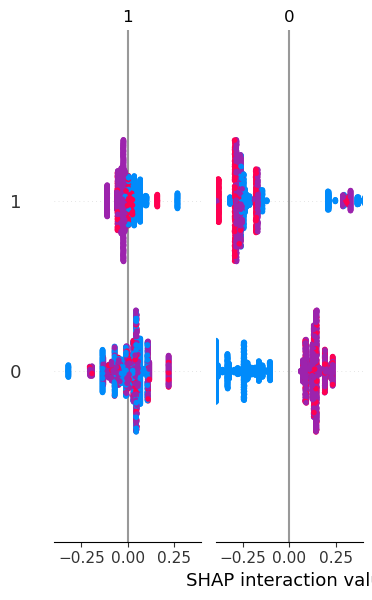

In [105]:
X_train_5_shap.columns = X_train_5_shap.columns.astype(str)
shap_test = shap.TreeExplainer(dtc).shap_values(X_train_5_shap)
shap.summary_plot(shap_test, X_train_5_shap, max_display=25, plot_size=None)

Наибольшее влияение на таргет имеет признак `level`. Далее примерно с одинаковой значимостью идут такие признаки, как `job_satisfaction_rate` и `employment_years`.

### Промежуточные выводы <a id='11'> <a>

<div class="alert"; style="border-left: 7px solid pink">

- Целевой признак был переведён в числовой формат для оптимальности работы модели;
- В признаковое описание `был добавлен` фактор удовлетворенности сотрудников работой, который был предсказан с использованием модели из `Задачи №1`
- Был составлен пайплайн с `двумя` методами масштабирования (`StandardScaler` и `MinMaxScaler`) и `четырьмя` моделями (`DecisionTreeClassifier`, `KNeighborsClassifier`, `SVC` и `LogisticRegression`). В результате работы этого пайплайна лучшей моделью оказалась `DecisionTreeClassifier` с  масштабированием `StandardScaler`. Метрика ROC-AU = `0.8999`;

Были предприняты 4 попытки `улучшения` модели с помощью отбора и синтеза признаков:
- Был убран признак `job_satisfaction_rate` => качество модели `понизилось` (`0.9015`)
- Был создан интегрированный признак `overall_satisfaction_rate`, рассчитанный по формуле 0.6×job_satisfaction_rate+0.4×supervisor_evaluation => качество модели `понизилось` (`0.8994`)
- Был убран признак workload => качество модели `понизилось` (`0.9025`)
- Были убраны признаки, которые `слабо коррелируют` таргетом (`last_year_promo`, `last_year_violations`, `dept`) => качество модели `повысилось` (`0.9029`).
- **Таким образом, лучшая модель по предсказанию следующая: LogisticRegression с гиперпараметром solver=newton-cg, C=100, penalty=None и масштабированием StandardScaler (начение roc_auc - 0.903).**
</div>

## Общий вывод <a id='12'> <a>

В рамках настоящего исследования анализировались данные о сотрудниках компании, которая хочет уметь предсказывать их удовлетворнность и вероятность ухода.

**В результате изучения и предобработки были опеределно:**
- В таблицах `train_job_satisfaction_rate` и `test_features` имелись пропуски (в том числе неявные) - они были заменены на наиболее частое значения с помощью Pipeline;
- Тренировочные данные имеют `4000` записей, тестовые - `2000`;
- Дубликаты `присутсвуют`, перед обучением они были удалены;
- Типы данных `в порядке`;
- Названия столбцов `в змеином порядке`.

**Данные о сотрудниках имели следующие характеристики:**
- Большинство сотрудников (75%) имеют стаж до 6 лет, в среднем 3-4 года, чаще всего 1-2 года.
- Сотрудники с опытом более 3 лет обычно не увольняются, за исключением случаев с 4-10 летним стажем.
- Распределение стажа смещено влево.
- Средняя оценка руководителя - 3.47/5, наиболее частая - 4.
- Оценки руководителя схожи у уволившихся и неуволившихся сотрудников.
- Присутствуют выбросы с оценкой 1.
- Распределение оценок нормальное.
- Средняя зарплата ~34 тыс. руб., минимальная - 12 тыс. руб., максимальная - ~100 тыс. руб.
- Распределение имеет нормальный вид, но смещено влево.
- Сотрудники с зарплатой >50 тыс. руб. обычно не увольняются, но есть исключения.
- Почти 40% из отдела продаж, более 1/5 - из ИТ отдела, остальные поровну распределены между hr, закупками и маркетингом.
- Чуть менее половины - junior, чуть более 40% - middle, менее 10% - senior.
- Для половины сотрудников загрузка была средней, для трети - низкой, для ~17-18% - высокой.
- Повышение получили ~3% сотрудников из тренировочных выборок.
- ~14% сотрудников нарушили правила в прошлом году.
- ~30% сотрудников из train_quit уволились.

**Был сформирован портрет "уволившегося сотрудника":**
- Стаж работы в компании: 1-3 года;
- Зарпалата: 12-40 тыс. руб. (в среднем ~24 тыс. руб. против ~38 тыс. руб. у неуволившихся);
- Департамент: продажи или ИТ;
- Должность: junior;
- Загрузка: низкая или средняя;
- Повышение в прошлом году: не было;
- Нарушения в прошлом году: в 8 случаев из 10 - нет, однако вероятность выше, чем у неуволившихся;
- Удовлетворенность работой: ~0.4/1.0 (против ~0.6/1.0 у неуволившихся).

**В рамках выполнения задачи №1:**

- Были обучены `две` модели (`линейная модель` и `дерево решений`)
- В результате DecisionTreeRegressor со StandardScaler - лучшая модель (SMAPE = 15.872 при кросс-валидации), что указывает на неплохое качество модели. Вторая по качеству модель также DecisionTreeRegressor, но с MinMaxScaler. LinearRegression значительно менее эффективна, возможно из-за отсутствия линейной корреляции между признаками и целевой переменной.

**В рамках выполнения задачи №2:**

- Целевой признак был переведён в числовой формат для оптимальности работы модели;
- В признаковое описание `был добавлен` фактор удовлетворенности сотрудников работой, который был предсказан с использованием модели из `Задачи №1`
- Был составлен пайплайн с `двумя` методами масштабирования (`StandardScaler` и `MinMaxScaler`) и `четырьмя` моделями (`DecisionTreeClassifier`, `KNeighborsClassifier`, `SVC` и `LogisticRegression`). В результате работы этого пайплайна лучшей моделью оказалась `DecisionTreeClassifier` с  масштабированием `StandardScaler`. Метрика ROC-AU = `0.8999`;

Были предприняты 4 попытки `улучшения` модели с помощью отбора и синтеза признаков:
- Был убран признак `job_satisfaction_rate` => качество модели `понизилось` (`0.9015`);
- Был создан интегрированный признак `overall_satisfaction_rate`, рассчитанный по формуле 0.6×job_satisfaction_rate+0.4×supervisor_evaluation => качество модели `понизилось` (`0.8994`);
- Был убран признак workload => качество модели `понизилось` (`0.9025`);
- Были убраны признаки, которые `слабо коррелируют` таргетом (`last_year_promo`, `last_year_violations`, `dept`) => качество модели `повысилось` (`0.9029`);
- Таким образом, лучшая модель по предсказанию была достигнута на 4 попытке: `DecisionTreeClassifier` с масштабированием `MinMaxScaler` и c гипермараметром `max_depth=4`, а данные при этом не включают такие признаки, как `last_year_promo`, `last_year_violations` и `dept`.

**Рекомендации для бизнеса:**
- Управление персоналом:
    - При управлении сотрудниками со стажем от 4 до 10 лет, следует обратить внимание на факторы, которые могут повлиять на их удовлетворенность и удержание.
    - Следует следить за уровнем удовлетворенности сотрудников с низкой и средней зарплатой, особенно в отделах продаж и ИТ, а также у junior сотрудников с низкой загрузкой.
- Оценка руководителей:
    - Следует обратить внимание на случаи выбросов с оценкой 1, а также провести анализ, чтобы понять причины низких оценок и предпримите меры для улучшения ситуации.
- Модель прогнозирования увольнений:
    - Следует использовать модель DecisionTreeClassifier с масштабированием StandardScaler для прогнозирования увольнений сотрудников.
    - Следует учесть, что убирание слабо коррелирующих признаков может улучшить точность модели.
- Следить за удовлетворенностью:
    - Следует уделять внимание фактору удовлетворенности сотрудников, поскольку он играет ключевую роль в предсказании увольнений.
- Обучение и развитие:
    - Следует повышать внимание к обучению и развитию сотрудников, особенно для тех, у кого стаж работы в компании от 1 до 3 лет.